In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cell 1: Import necessary libraries
from avcv.all import *
import torch
import os
from diffsynth import ModelManager, HunyuanDiTImagePipeline
from PIL import Image
from diffsynth import save_video, ModelManager, SVDVideoPipeline, HunyuanDiTImagePipeline


In [3]:
%%time
os.environ["TOKENIZERS_PARALLELISM"] = "True"
# Load models
model_manager = ModelManager(torch_dtype=torch.float16, device="cuda", model_id_list=["stable-video-diffusion-img2vid-xt", "ExVideo-SVD-128f-v1"])
pipe = SVDVideoPipeline.from_model_manager(model_manager)

svd_xt.safetensors has been already in models/stable_video_diffusion.
model.fp16.safetensors has been already in models/stable_video_diffusion.
CPU times: user 1min 31s, sys: 29.8 s, total: 2min 1s
Wall time: 22.2 s


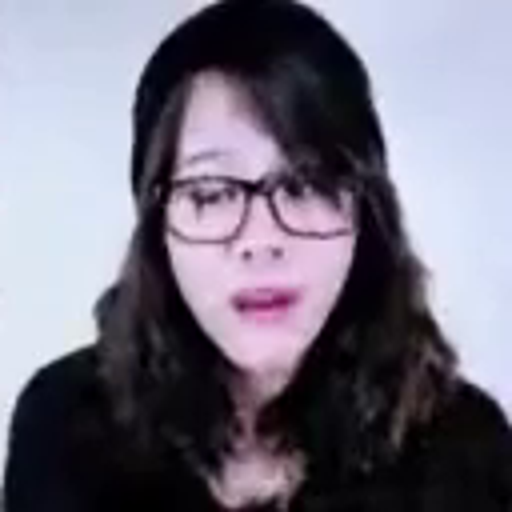

In [4]:
# Prepare input image
image = Image.open('image.png')
height = 512
width = 512

input_image = image.resize((width, height))
input_image_512 = image.resize((512, 512))
input_image

In [5]:
# Cell 2: Set up parameters and prepare latent tensors
num_frames = 24
num_inference_steps = 15
denoising_strength = 1.0
noise_aug_strength = 0.02
min_cfg_scale = 1.0
max_cfg_scale = 3.0
fps = 15
motion_bucket_id = 127

pipe.scheduler.set_timesteps(num_inference_steps, denoising_strength=denoising_strength)


In [6]:

noise = torch.randn((num_frames, 4, height//8, width//8), device="cpu", dtype=pipe.torch_dtype).to(pipe.device)
latents = noise.clone()

# Cell 3: Encode image
image_emb_clip_posi = pipe.encode_image_with_clip(input_image_512)
image_emb_clip_nega = torch.zeros_like(image_emb_clip_posi)
image_emb_vae_posi = pipe.encode_image_with_vae(input_image, noise_aug_strength).repeat(num_frames, 1, 1, 1)
image_emb_vae_nega = torch.zeros_like(image_emb_vae_posi)


In [7]:
# Cell 4: Prepare classifier-free guidance
cfg_scales = torch.linspace(min_cfg_scale, max_cfg_scale, num_frames)
cfg_scales = cfg_scales.reshape(num_frames, 1, 1, 1).to(device=pipe.device, dtype=pipe.torch_dtype)

# Cell 5: Prepare positional id
add_time_id = torch.tensor([[fps-1, motion_bucket_id, noise_aug_strength]], device=pipe.device)

In [8]:
# Cell 6: Denoising loop
from tqdm import tqdm
import torch
with torch.inference_mode():
    pbar = pipe.scheduler.timesteps
    for progress_id, timestep in enumerate(pbar):
        # Fetch model output
        noise_pred = pipe.calculate_noise_pred(
            latents, timestep, add_time_id, cfg_scales,
            image_emb_vae_posi, image_emb_clip_posi, image_emb_vae_nega, image_emb_clip_nega
        )
    
        # Forward Euler
        latents = pipe.scheduler.step(noise_pred, timestep, latents)
    
        print(f"Step {progress_id+1}/{len(pipe.scheduler.timesteps)} completed")
# Cell 7: Decode image
with torch.inference_mode():
    latents = pipe.post_process_latents(latents)
    video = pipe.vae_decoder.decode_video(latents)
    video = pipe.tensor2video(video)

# Cell 8: Save video
save_video(video, 'output_video.mp4', fps=fps)
# load and view videos

Step 1/15 completed
Step 2/15 completed
Step 3/15 completed
Step 4/15 completed
Step 5/15 completed
Step 6/15 completed
Step 7/15 completed
Step 8/15 completed
Step 9/15 completed
Step 10/15 completed
Step 11/15 completed
Step 12/15 completed
Step 13/15 completed
Step 14/15 completed
Step 15/15 completed


Saving video: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.20it/s]


# Load frames

In [9]:
torch.cuda.empty_cache()

In [10]:
# Cell 2: Set up parameters and prepare latent tensors
num_frames = 60
num_inference_steps = 20
denoising_strength = 0.5
noise_aug_strength = 0.02
min_cfg_scale = 2
max_cfg_scale = 2
fps = 15
motion_bucket_id = 127

pipe.scheduler.set_timesteps(num_inference_steps, denoising_strength=denoising_strength)


In [11]:
raw_frames = list(mmcv.VideoReader('/tmp/videoplayback.mp4'))[10:10+num_frames]
raw_frames = [frame[:, 128:, ::-1] for frame in raw_frames]
raw_frames = [Image.fromarray(raw_frame).resize((512, 512)) for raw_frame in raw_frames]

/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [13]:
import torch
from torchvision.transforms import v2
from einops import rearrange
import numpy as np

import torchvision.transforms as transforms

height, width = 512, 512
with torch.no_grad():
    raw_latents = pipe.encode_video_with_vae(raw_frames)
    noise = torch.randn((num_frames, 4, height//8, width//8), device="cpu", dtype=pipe.torch_dtype).to(pipe.device)
    latents = pipe.scheduler.add_noise(raw_latents, noise, pipe.scheduler.timesteps[-1])


In [17]:
input_image_512 = raw_frames[0]
# Cell 3: Encode image
image_emb_clip_posi = pipe.encode_image_with_clip(input_image_512)
image_emb_clip_nega = torch.zeros_like(image_emb_clip_posi)
image_emb_vae_posi = pipe.encode_image_with_vae(input_image_512, noise_aug_strength).repeat(num_frames, 1, 1, 1)
image_emb_vae_nega = torch.zeros_like(image_emb_vae_posi)


In [18]:
# Cell 4: Prepare classifier-free guidance
cfg_scales = torch.linspace(min_cfg_scale, max_cfg_scale, num_frames)
cfg_scales = cfg_scales.reshape(num_frames, 1, 1, 1).to(device=pipe.device, dtype=pipe.torch_dtype)

# Cell 5: Prepare positional id
add_time_id = torch.tensor([[fps-1, motion_bucket_id, noise_aug_strength]], device=pipe.device)

In [19]:
# Cell 6: Denoising loop
from tqdm import tqdm
import torch
with torch.inference_mode():
    # pbar = tqdm(pipe.scheduler.timesteps)
    pbar = pipe.scheduler.timesteps
    for progress_id, timestep in enumerate(pbar):
        # Fetch model output
        noise_pred = pipe.calculate_noise_pred(
            latents, timestep, add_time_id, cfg_scales,
            image_emb_vae_posi, image_emb_clip_posi, image_emb_vae_nega, image_emb_clip_nega
        )
    
        # Forward Euler
        # latents = pipe.scheduler.step(noise_pred, timestep, latents).prev_sample
        latents = pipe.scheduler.step(noise_pred, timestep, latents)
    
        print(f"Step {progress_id+1}/{len(pipe.scheduler.timesteps)} completed")
# Cell 7: Decode image
with torch.inference_mode():
    latents = pipe.post_process_latents(latents)
    video = pipe.vae_decoder.decode_video(latents)
    video = pipe.tensor2video(video)

# Cell 8: Save video
save_video(video, 'output_video.mp4', fps=fps)

Step 1/20 completed
Step 2/20 completed
Step 3/20 completed
Step 4/20 completed
Step 5/20 completed
Step 6/20 completed
Step 7/20 completed
Step 8/20 completed
Step 9/20 completed
Step 10/20 completed
Step 11/20 completed
Step 12/20 completed
Step 13/20 completed
Step 14/20 completed
Step 15/20 completed
Step 16/20 completed
Step 17/20 completed
Step 18/20 completed
Step 19/20 completed
Step 20/20 completed


Saving video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 225.75it/s]


In [ ]:
# Cell 7: Decode image
with torch.inference_mode():
    latents = pipe.post_process_latents(latents)
    video = pipe.vae_decoder.decode_video(latents)
    video = pipe.tensor2video(video)

# Cell 8: Save video
save_video(video, 'output_video.mp4', fps=fps)

In [21]:
print(osp.abspath('output_video.mp4'))

/anhvth5/vision-projects/DiffSynth-Studio/output_video.mp4


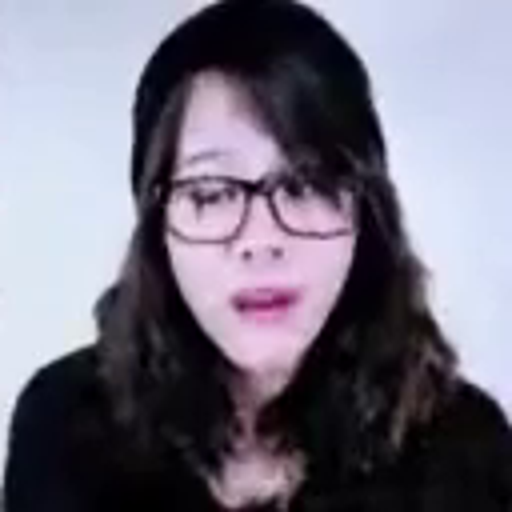

In [19]:
image = raw_frames[0]
image

In [21]:
model_manager.to('cuda:0')

In [73]:
# Generate a video
torch.manual_seed(2)
size = 512
image = Image.open('image (1).png').resize((size, size))
image = np.array(image)[...,:3]
image = Image.fromarray(image)

video = pipe(
    input_image=image,
    input_video=[frame.resize((size, size)) for frame in raw_frames], 
    denoising_strength=0.5,
    num_frames=len(raw_frames), 
    fps=30, height=size, width=size,
    motion_bucket_id=len(raw_frames)-1,
    num_inference_steps=10,
    min_cfg_scale=2, max_cfg_scale=2, contrast_enhance_scale=1.2
)
save_video([frame.resize((size, size)) for frame in video], "video_512.mp4", fps=30)

Saving video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 197.61it/s]


In [44]:
raw_frames[0].save('image.png')

# Pipelines

## Basic

AttributeError: 'SVDVideoPipeline' object has no attribute 'vae'

SVDVideoPipeline(
  (image_encoder): SVDImageEncoder(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
    )
    (pre_layernorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (encoders): ModuleList(
      (0-31): 32 x CLIPEncoderLayer(
        (attn): Attention(
          (to_q): Linear(in_features=1280, out_features=1280, bias=True)
          (to_k): Linear(in_features=1280, out_features=1280, bias=True)
          (to_v): Linear(in_features=1280, out_features=1280, bias=True)
          (to_out): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
    )
    (post_layernorm): Laye

In [ ]:
def text_to_image(prompt, num_inference_steps=50, guidance_scale=7.5, height=512, width=512):
    # Encode the prompt
    text_input = clip.tokenizer(prompt, padding="max_length", max_length=clip.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = clip.text_model(text_input.input_ids.to(device))[0]

    # Create uncond embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = clip.tokenizer([""] * 1, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = clip.text_model(uncond_input.input_ids.to(device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prepare initial latents
    latents = torch.randn((1, unet.config.in_channels, height // 8, width // 8)).to(device)

    # Set timesteps
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")[0]

    return image

# Generate an image
prompt = "A beautiful landscape with mountains and a lake"
generated_image = text_to_image(prompt)

# Display the image
from PIL import Image
Image.fromarray(generated_image)


# SAG

In [2]:
from diffusers import StableDiffusionSAGPipeline, StableDiffusionPipeline

/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
import torch
from diffusers import StableDiffusionSAGPipeline
# StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe_sag = StableDiffusionSAGPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe_sag.to('cuda')


/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionSAGPipeline {
  "_class_name": "StableDiffusionSAGPipeline",
  "_diffusers_version": "0.22.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

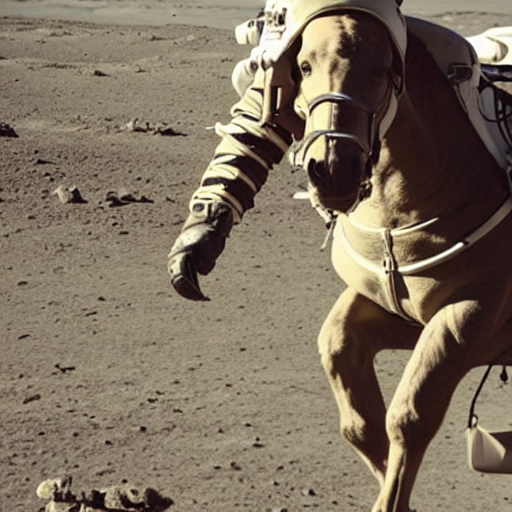

In [5]:
prompt = "a photo of an astronaut riding a horse on mars"
g = torch.Generator(42)
image = pipe_sag(prompt, generator=g, sag_scale=0.5).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

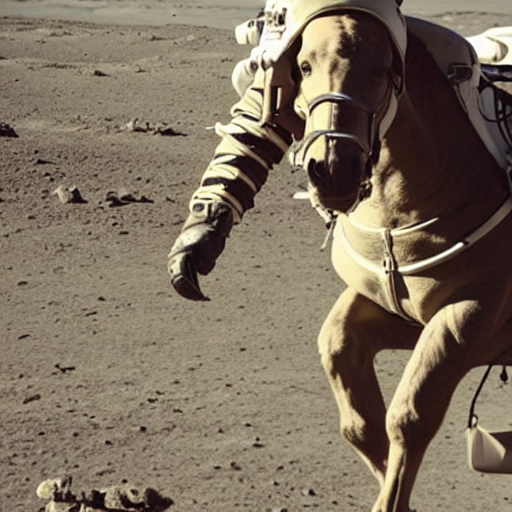

In [17]:
g = torch.Generator(42)
image_sag = pipe_sag(prompt, sag_scale=0.5, generator=g).images[0]
image_sag